In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D
import plotly.figure_factory as ff
from scipy.spatial import Delaunay

In [2]:
# Create model for u
u_model = Sequential()
u_model.add(Dense(100, input_shape=[1], activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(1))

# Create model for lambda, lambda already defined :(
lamda_model = Sequential()
lamda_model.add(Dense(100, input_shape=[1], activation='relu'))
lamda_model.add(Dense(100, activation='relu'))
lamda_model.add(Dense(100, activation='relu'))
lamda_model.add(Dense(100, activation='relu'))
lamda_model.add(Dense(100, activation='relu'))
lamda_model.add(Dense(100, activation='relu'))
lamda_model.add(Dense(1))

In [15]:
# Boundary function f(0)=0, f(1)=1
def bnd_f(x):
    y = np.heaviside(x-1, 1)
    return y

In [16]:
# u loss function
def u_loss(u_model, lamda_model, x):
    with tf.GradientTape() as t:
        t.watch(x)
        u = u_model(x, training=True)
        #print('u = ', u)
    du_dx = t.gradient(u,x)
    dirichlet_energy = tf.nn.l2_loss(du_dx)
    
    lamda = lamda_model(x,training=False) # Not sure if x needs to be just on boundary
    lagrangian = lamda * (u - bnd_f(x))
    lagrange_loss = tf.math.reduce_mean(lagrangian)
    
    loss = dirichlet_energy + lagrange_loss
    return loss


# lambda loss function
def lamda_loss(u_model, lamda_model, x): # Not sure if x needs to be just on boundary
    lamda = -1 * lamda_model(x,training=True)
    u = u_model(x, training=False)
    lagrangian = lamda * (u - bnd_f(x))
    
    loss = tf.math.reduce_sum(lagrangian)
    return loss

In [17]:
def train_u(epochs):
    optimizer = tf.keras.optimizers.Ftrl() # Fancy gradient decent
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100
    minibatch_size = 100 # Number of points to be selected each iteration

    for epoch in range(epochs): 
        epoch_loss_avg = tf.keras.metrics.Mean()
        for iteration in range(iterations_per_epoch):
            lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
            upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
            interior_pts = tf.random.uniform(shape=[1, minibatch_size-2]) # Interior points
            x = tf.transpose(tf.concat([lower_bound, interior_pts, upper_bound], 1)) # Actual training data
            with tf.GradientTape() as t:
                t.watch(x)
                #print(x)
                #f = u_model(x, training=True) # Estimate for u
                loss = u_loss(u_model, lamda_model, x) # Loss
            grads = t.gradient(loss, u_model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, u_model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

def train_lamda(epochs):
    optimizer = tf.keras.optimizers.Ftrl() # Fancy gradient decent
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100
    minibatch_size = 100 # Number of points to be selected each iteration

    for epoch in range(epochs): 
        epoch_loss_avg = tf.keras.metrics.Mean()
        for iteration in range(iterations_per_epoch):
            lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
            upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
            interior_pts = tf.random.uniform(shape=[1, minibatch_size-2]) # Interior points
            x = tf.transpose(tf.concat([lower_bound, interior_pts, upper_bound], 1)) # Actual training data
            with tf.GradientTape() as t:
                t.watch(x)
                #print(x)
                #f = u_model(x, training=True) # Estimate for u
                loss = lamda_loss(u_model, lamda_model, x) # Loss
            grads = t.gradient(loss, lamda_model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, lamda_model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

def training_loop(total_iterations, u_epochs, lamda_epochs):
    for i in range(total_iterations):
        print("Iteration {:03d}:".format(i))
        print("Training u...")
        train_u(u_epochs)
        print("Training lambda...")
        train_lamda(lamda_epochs)

In [18]:
training_loop(10,5,1)

Iteration 000:
Training u...
Epoch 000: Loss: 0.000
Epoch 001: Loss: 0.000
Epoch 002: Loss: -0.000
Epoch 003: Loss: -0.000
Epoch 004: Loss: -0.000
Training lambda...
Epoch 000: Loss: 0.003
Iteration 001:
Training u...
Epoch 000: Loss: -0.000
Epoch 001: Loss: -0.000
Epoch 002: Loss: -0.000
Epoch 003: Loss: -0.000
Epoch 004: Loss: -0.000
Training lambda...
Epoch 000: Loss: -0.014
Iteration 002:
Training u...
Epoch 000: Loss: 0.000
Epoch 001: Loss: 0.000
Epoch 002: Loss: -0.000
Epoch 003: Loss: -0.000
Epoch 004: Loss: -0.000
Training lambda...
Epoch 000: Loss: -0.002
Iteration 003:
Training u...
Epoch 000: Loss: -0.000
Epoch 001: Loss: -0.000
Epoch 002: Loss: -0.000
Epoch 003: Loss: -0.000
Epoch 004: Loss: -0.000
Training lambda...
Epoch 000: Loss: -0.010
Iteration 004:
Training u...
Epoch 000: Loss: 0.000
Epoch 001: Loss: 0.000
Epoch 002: Loss: 0.000
Epoch 003: Loss: -0.000
Epoch 004: Loss: -0.000
Training lambda...
Epoch 000: Loss: -0.003
Iteration 005:
Training u...
Epoch 000: Loss: -0

0.48568145751953123


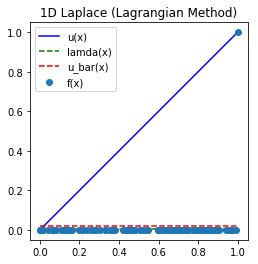

In [21]:
lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
x = tf.sort(tf.random.uniform(shape=[1,98])) # Interior points
test_points_tensor = tf.transpose(tf.concat([lower_bound, x, upper_bound], 1)) # Actual data
test_points = test_points_tensor.numpy()
u_bar = u_model(test_points_tensor, training=False).numpy()
lamda = lamda_model(test_points_tensor, training=False).numpy()
f = bnd_f(test_points)
x_actual = tf.sort(tf.random.uniform(shape=[1,1000]).numpy()) # Known solution
#print(test_points[0])
#print(x_actual[0])
#print(f[0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('1D Laplace (Lagrangian Method)')
ax.plot(x_actual[0],x_actual[0], label='u(x)', color='blue')
ax.plot(test_points, lamda, 'g--', label='lamda(x)')
ax.plot(test_points, u_bar, 'r--', label='u_bar(x)')
ax.plot(test_points, f, 'o', label='f(x)')
ax.legend()
ax.set_aspect('equal','box')

tikzplotlib.save("1d_laplace_lagrangian.tex")

average_error = np.sum(abs(u_bar-test_points))/len(u_bar)
print(average_error)